In [ ]:
import pandas as pd
import geopandas as gpd
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg
from shapely.geometry import LineString
import matplotlib as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt2
import rasterio as rio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Taxi_NYC = pd.read_csv('/content/drive/MyDrive/ds-project-raster-compare/datasets/nyc1.csv')

In [ ]:
    # Convert Long Lat into numeric type
Taxi_NYC['Pickup_longitude'] = pd.to_numeric(Taxi_NYC['Pickup_longitude'])
Taxi_NYC['Pickup_latitude'] = pd.to_numeric(Taxi_NYC['Pickup_latitude'])
Taxi_NYC['Dropoff_longitude'] = pd.to_numeric(Taxi_NYC['Dropoff_longitude'])
Taxi_NYC['Dropoff_latitude'] = pd.to_numeric(Taxi_NYC['Dropoff_latitude'])
print(Taxi_NYC)

              id  VendorID lpep_pickup_datetime Lpep_dropoff_datetime  \
0              0         2  2016-01-01 00:29:24   2016-01-01 00:39:36   
1              1         2  2016-01-01 00:19:39   2016-01-01 00:39:18   
2              2         2  2016-01-01 00:19:33   2016-01-01 00:39:48   
3              3         2  2016-01-01 00:22:12   2016-01-01 00:38:32   
4              4         2  2016-01-01 00:24:01   2016-01-01 00:39:22   
...          ...       ...                  ...                   ...   
1445280  1445280         2  2016-01-31 23:59:36   2016-02-01 00:07:53   
1445281  1445281         2  2016-01-31 23:26:06   2016-01-31 23:31:22   
1445282  1445282         2  2016-01-31 23:50:36   2016-01-31 23:56:19   
1445283  1445283         2  2016-01-31 23:57:47   2016-02-01 00:06:58   
1445284  1445284         2  2016-01-31 23:59:54   2016-02-01 00:07:06   

        Store_and_fwd_flag  RateCodeID  Pickup_longitude  Pickup_latitude  \
0                        N           1        

In [ ]:
# Convert Long Lat into Point Geometry

pickup_points = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x=Taxi_NYC['Pickup_longitude'], y=Taxi_NYC['Pickup_latitude']))
dropoff_points = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x=Taxi_NYC['Dropoff_longitude'], y=Taxi_NYC['Dropoff_latitude']))

print(pickup_points)
print(dropoff_points)


                           geometry
0        POINT (-73.92864 40.68061)
1        POINT (-73.95267 40.72318)
2        POINT (-73.97161 40.67611)
3        POINT (-73.98950 40.66958)
4        POINT (-73.96473 40.68285)
...                             ...
1445280  POINT (-73.80772 40.70045)
1445281  POINT (-73.95141 40.71400)
1445282  POINT (-73.95484 40.73021)
1445283  POINT (-73.95349 40.81721)
1445284  POINT (-73.89258 40.74725)

[1445285 rows x 1 columns]
                           geometry
0        POINT (-73.92428 40.69804)
1        POINT (-73.92392 40.76138)
2        POINT (-74.01316 40.64607)
3        POINT (-74.00065 40.68903)
4        POINT (-73.94072 40.66301)
...                             ...
1445280  POINT (-73.76848 40.69808)
1445281  POINT (-73.94148 40.72477)
1445282  POINT (-73.94463 40.72630)
1445283  POINT (-73.97713 40.77958)
1445284  POINT (-73.91005 40.77554)

[1445285 rows x 1 columns]


In [ ]:
# prompt: concatenate the pickup_pointss and the dropoff_pointss

nyc_points = pd.concat([pickup_points, dropoff_points], ignore_index=True)
print(nyc_points)

                           geometry
0        POINT (-73.92864 40.68061)
1        POINT (-73.95267 40.72318)
2        POINT (-73.97161 40.67611)
3        POINT (-73.98950 40.66958)
4        POINT (-73.96473 40.68285)
...                             ...
2890565  POINT (-73.76848 40.69808)
2890566  POINT (-73.94148 40.72477)
2890567  POINT (-73.94463 40.72630)
2890568  POINT (-73.97713 40.77958)
2890569  POINT (-73.91005 40.77554)

[2890570 rows x 1 columns]


In [ ]:
# prompt: i want the ten maximum and minimum values from x and y and display them

minimum_x = nyc_points.geometry.x.min()
maximum_x = nyc_points.geometry.x.max()
minimum_y = nyc_points.geometry.y.min()
maximum_y = nyc_points.geometry.y.max()

print("Minimum x:", minimum_x)
print("Maximum x:", maximum_x)
print("Minimum y:", minimum_y)
print("Maximum y:", maximum_y)

# Get the ten maximum and minimum values from x and y
max_x_values = nyc_points.geometry.x.nlargest(10)
min_x_values = nyc_points.geometry.x.nsmallest(10)
max_y_values = nyc_points.geometry.y.nlargest(10)
min_y_values = nyc_points.geometry.y.nsmallest(10)

# Display the maximum and minimum values
print("Maximum x values:", max_x_values, sep = "\n")
print("Minimum x values:", min_x_values, sep = "\n")
print("Maximum y values:", max_y_values, sep = "\n")
print("Minimum y values:", min_y_values, sep = "\n")


Minimum x: -115.18130493164062
Maximum x: 0.0
Minimum y: 0.0
Maximum y: 43.168006896972656
Maximum x values:
5239     0.0
6216     0.0
6424     0.0
7355     0.0
9219     0.0
10835    0.0
12381    0.0
12618    0.0
12888    0.0
13239    0.0
dtype: float64
Minimum x values:
1203026   -115.181305
2822033   -115.178856
1421710   -115.177605
1411369   -115.177559
1443756   -115.175995
2842901   -115.175560
2889042   -115.175484
1384820   -115.175385
2752958   -115.175354
2761383   -115.175308
dtype: float64
Maximum y values:
1219444    43.168007
2073455    42.694790
635770     42.694782
635904     42.694782
2081055    42.694782
2081189    42.694782
635820     42.694775
2081105    42.694775
1028932    42.324322
1028933    42.324322
dtype: float64
Minimum y values:
5239     0.0
6216     0.0
6424     0.0
7355     0.0
9219     0.0
10835    0.0
12381    0.0
12618    0.0
12888    0.0
13239    0.0
dtype: float64


In [ ]:
print(nyc_points)

                           geometry
0        POINT (-73.92864 40.68061)
1        POINT (-73.95267 40.72318)
2        POINT (-73.97161 40.67611)
3        POINT (-73.98950 40.66958)
4        POINT (-73.96473 40.68285)
...                             ...
2890565  POINT (-73.76848 40.69808)
2890566  POINT (-73.94148 40.72477)
2890567  POINT (-73.94463 40.72630)
2890568  POINT (-73.97713 40.77958)
2890569  POINT (-73.91005 40.77554)

[2890570 rows x 1 columns]


In [ ]:
import numpy as np
from scipy import stats
import geopandas as gpd

def remove_outliers_zscore(geodataframe, threshold=3):
    # Extracting coordinates from geometry
    coords = np.array([(point.x, point.y) for point in geodataframe.geometry])

    # Calculating z-scores for both longitude and latitude
    z_scores_lon = np.abs(stats.zscore(coords[:, 0]))
    z_scores_lat = np.abs(stats.zscore(coords[:, 1]))

    # Find outliers for both longitude and latitude
    outliers = (z_scores_lon > threshold) | (z_scores_lat > threshold)

    # Remove outliers
    cleaned_geodataframe = geodataframe[~outliers].copy()
    return cleaned_geodataframe

In [ ]:
nyc_points = remove_outliers_zscore(nyc_points)

In [ ]:
# prompt: i want the ten maximum and minimum values from x and y and display them

minimum_x = nyc_points.geometry.x.min()
maximum_x = nyc_points.geometry.x.max()
minimum_y = nyc_points.geometry.y.min()
maximum_y = nyc_points.geometry.y.max()

print("Minimum x:", minimum_x)
print("Maximum x:", maximum_x)
print("Minimum y:", minimum_y)
print("Maximum y:", maximum_y)

# Get the ten maximum and minimum values from x and y
max_x_values = nyc_points.geometry.x.nlargest(10)
min_x_values = nyc_points.geometry.x.nsmallest(10)
max_y_values = nyc_points.geometry.y.nlargest(10)
min_y_values = nyc_points.geometry.y.nsmallest(10)

# Display the maximum and minimum values
print("Maximum x values:", max_x_values, sep = "\n")
print("Minimum x values:", min_x_values, sep = "\n")
print("Maximum y values:", max_y_values, sep = "\n")
print("Minimum y values:", min_y_values, sep = "\n")

Minimum x: -78.25851440429688
Maximum x: -70.14051818847656
Minimum y: 37.52218627929688
Maximum y: 43.168006896972656
Maximum x values:
1199026   -70.140518
343100    -71.070084
1788385   -71.070107
1028934   -71.070122
343067    -71.070152
1028932   -71.070175
2474219   -71.070175
1028935   -71.070183
1788185   -71.070183
1788352   -71.070183
dtype: float64
Minimum x values:
280751    -78.258514
1967689   -77.526421
2717555   -76.685287
1272270   -76.432892
2553028   -75.939247
1107743   -75.938301
2553031   -75.932281
1107746   -75.932205
1107744   -75.926674
1107747   -75.925430
dtype: float64
Maximum y values:
1219444    43.168007
2073455    42.694790
635770     42.694782
635904     42.694782
2081055    42.694782
2081189    42.694782
635820     42.694775
2081105    42.694775
1028932    42.324322
1028933    42.324322
dtype: float64
Minimum y values:
280751     37.522186
1272270    38.197365
2717555    38.633171
1568428    39.355820
123143     39.356133
2777886    39.374725
2767190 

In [ ]:
print(nyc_points)

                           geometry
0        POINT (-73.92864 40.68061)
1        POINT (-73.95267 40.72318)
2        POINT (-73.97161 40.67611)
3        POINT (-73.98950 40.66958)
4        POINT (-73.96473 40.68285)
...                             ...
2890565  POINT (-73.76848 40.69808)
2890566  POINT (-73.94148 40.72477)
2890567  POINT (-73.94463 40.72630)
2890568  POINT (-73.97713 40.77958)
2890569  POINT (-73.91005 40.77554)

[2885598 rows x 1 columns]


In [ ]:
nyc_points = nyc_points.set_crs('EPSG:4326')
nyc_points = nyc_points.to_crs('EPSG:3857')
nyc_points['value'] = 1
nyc_points = nyc_points[nyc_points.is_valid]
nyc_points = nyc_points[~nyc_points.is_empty]

In [ ]:
Taxi_NYC_raster = make_geocube(
        vector_data = nyc_points,
        measurements = ["value"],
        resolution = (-400, 400),
        rasterize_function=partial(rasterize_image, merge_alg=MergeAlg.add),
        fill = 0)

In [ ]:
Taxi_NYC_raster.rio.to_raster(r'/content/drive/MyDrive/ds-project-raster-compare/datasets/Taxi_NYC2.tiff')

In [ ]:
landsat = rio.open("/content/drive/MyDrive/ds-project-raster-compare/datasets/Taxi_NYC2.tiff")

In [ ]:
# The CRS
landsat.crs

CRS.from_epsg(3857)

In [ ]:
# The bounds
landsat.bounds

BoundingBox(left=-8712000.0, bottom=4512000.0, right=-7808000.0, top=5337600.0)

In [ ]:
# The number of bands available
landsat.count

1

In [ ]:
# The band numbers that are available
landsat.indexes

(1,)

In [ ]:
# Number of pixels in the x and y directions
landsat.shape

(2064, 2260)

In [ ]:
# The 6 parameters that map from pixel to real space
landsat.transform

Affine(400.0, 0.0, -8712000.0,
       0.0, -400.0, 5337600.0)

In [ ]:
# All of the meta data
landsat.meta

{'driver': 'GTiff',
 'dtype': 'int64',
 'nodata': 0.0,
 'width': 2260,
 'height': 2064,
 'count': 1,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(400.0, 0.0, -8712000.0,
        0.0, -400.0, 5337600.0)}

In [ ]:
# This is just a numpy array
data = landsat.read(1)
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

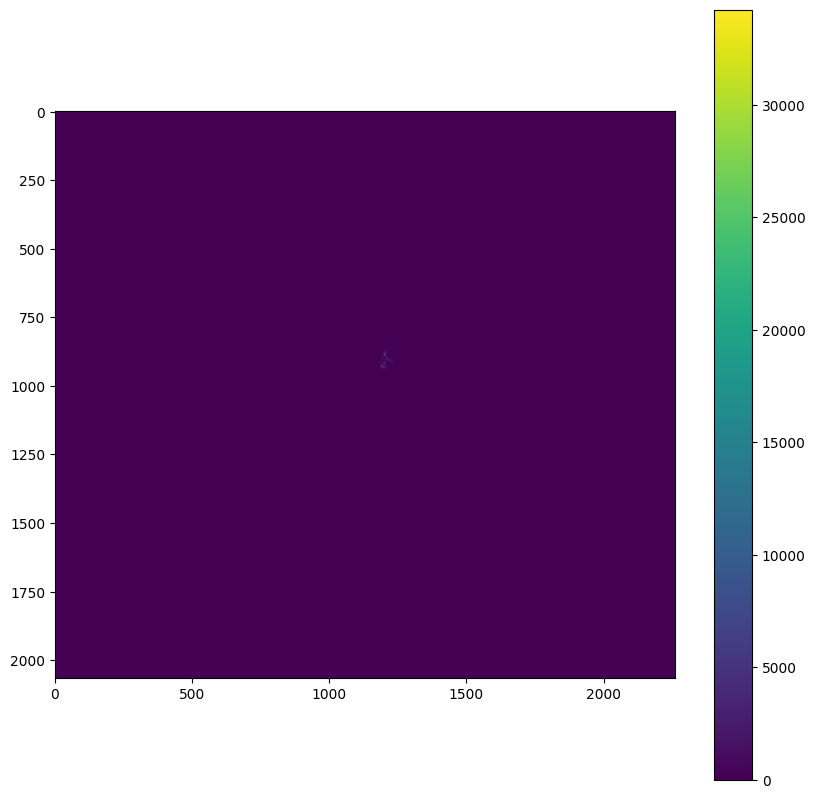

In [ ]:
fig, ax = plt2.subplots(figsize=(10,10))

img = ax.imshow(data)

plt2.colorbar(img)

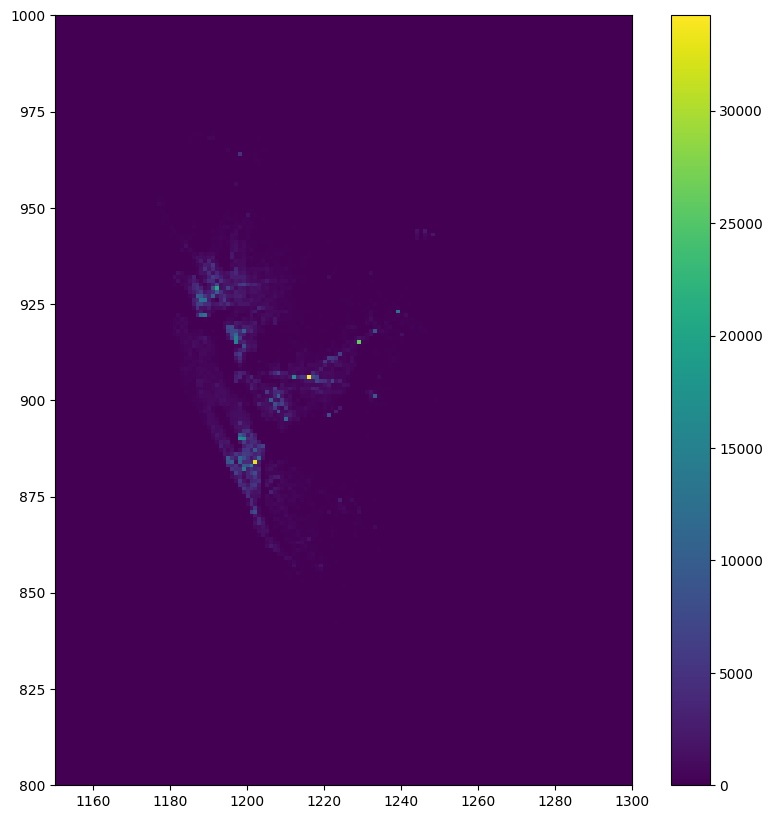

In [ ]:

import matplotlib.pyplot as plt

# Define the range to focus on
xmin, xmax = 1150, 1300  # Example range for x-axis
ymin, ymax = 800, 1000  # Example range for y-axis

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the data
img = ax.imshow(data)

# Set the limits of the axis to crop the plot
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Add colorbar
plt.colorbar(img)

# Show plot
plt.show()